# Nesting in the Similarity Model

In this notebook we present an example how the Similarity nesting structure may be specified. We also utilize the added flexibility of the Similarity Model to specify 'continuous nests' of our continuous covariates. First we present the general setup.

In [11]:
import numpy as np
import pandas as pd
#pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
import os
import sys
from numpy import linalg as la
from scipy import optimize
import scipy.stats as scstat
from matplotlib import pyplot as plt
import itertools as iter
%load_ext line_profiler

# Files
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utilities.Logit_file import estimate_logit, logit_se, logit_t_p, q_logit, logit_score, logit_score_unweighted, logit_ccp, LogitBLP_estimator, LogitBLP_se
from data.Eurocarsdata_file import Eurocars_cleandata

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [12]:
# Load dataset and variable names
descr = (pd.read_stata('../data/eurocars.dta', iterator = True)).variable_labels() # Obtain variable descriptions
dat_file = pd.read_csv('../data/eurocars.csv') # reads in the data set as a pandas dataframe.

In [13]:
# Outside option is included if OO == True, otherwise analysis is done on the inside options only.
OO = True

# Choose which variables to include in the analysis, and assign them either as discrete variables or continuous.

x_discretevars = [ 'brand', 'home', 'cla']
x_contvars = ['cy', 'hp', 'we', 'le', 'wi', 'he', 'li', 'sp', 'ac', 'pr']
z_IV_contvars = ['xexr']
z_IV_discretevars = []
x_allvars =  [*x_contvars, *x_discretevars]
z_allvars = [*z_IV_contvars, *z_IV_discretevars]

if OO:
    nest_contvars = [var for var in x_contvars if var != 'pr'] # We nest over all variables other than price, but an alternative list can be specified here if desired.
    nest_discvars = ['in_out', *x_discretevars]
    nest_vars = ['in_out', *nest_contvars, *x_discretevars]
else:
    nest_contvars = [var for var in x_contvars if (var != 'pr')]
    nest_discvars = x_discretevars # See above
    nest_vars = [*nest_contvars, *nest_discvars]

G = len(nest_vars)

# Print list of chosen variables as a dataframe
pd.DataFrame(descr, index=['description'])[x_allvars].transpose().reset_index().rename(columns={'index' : 'variable names'})

,variable names,description
0,cy,cylinder volume or displacement (in cc)
1,hp,horsepower (in kW)
2,we,weight (in kg)
3,le,length (in cm)
4,wi,width (in cm)
5,he,height (in cm)
6,li,"average of li1, li2, li3 (used in papers)"
7,sp,maximum speed (km/hour)
8,ac,time to acceleration (in seconds from 0 to 100...
9,pr,price (in destination currency including V.A.T.)


In [14]:
dat, dat_org, x_vars, z_vars, N, pop_share, T, J, K = Eurocars_cleandata(dat_file, x_contvars, x_discretevars, z_IV_contvars, z_IV_discretevars, outside_option=OO)

In [15]:
# Create dictionaries of numpy arrays for each market. This allows the size of the data set to vary over markets.

dat = dat.reset_index(drop = True).sort_values(by = ['market', 'co']) # Sort data so that reshape is successfull

x = {t: dat[dat['market'] == t][x_vars].values.reshape((J[t],K)) for t in np.arange(T)} # Dict of explanatory variables
y = {t: dat[dat['market'] == t]['ms'].to_numpy().reshape((J[t])) for t in np.arange(T)} # Dict of market shares

## Perturbed utility, logit and nested logit

In the following, a vector $z\in \mathbb R^d$ is always a column vector. The Similarity Model is a discrete choice model, where the probability vector over the alternatives is given by the solution to a utility maximization problem of the form
$$
P(u|\theta)=\arg\max_{q\in \Delta} q'u(\theta)-\Omega(q|\theta)
$$
where $\Delta$ is the probability simplex over the set of discrete choices, $u$ is a vector of payoffs for each option, $\Omega$ is a convex function and $q'$ denotes the transpose of $q$, and $\theta$ is a vector of parameters. All Additive Random Utility Models can be represented in this way (Fosgerau and Sørensen (2021)). For example, the logit choice probabilities result from the perturbation function $\Omega(q)=q'\ln q$ where $\ln q$ is the elementwise logarithm.

In the Nested Logit Model, the choice set is divided into a partition $\mathcal C=\left\{C_1,\ldots,C_L\right\}$, and the perturbation function is given by
$$
\Omega(q|\lambda)=(1-\lambda)q'\ln q+\lambda \sum_{\ell =1}^L \left( \sum_{j\in C_\ell}q_j\right)\ln \left( \sum_{j\in C}q_j\right),
$$
where $\lambda\in [0,1)$ is a parameter. This function can be written equivalently as
$$
\Omega(q|\lambda)=(1-\lambda)q'\ln q+\lambda \left(\psi q\right)'\ln \left( \psi q\right),
$$
where $\psi$ is a $J \times L$ matrix, where $\psi_{j\ell}=1$ if option $j$ belongs to nest $C_\ell$ and zero otherwise.
 This specification generates nested logit choice probabilities.

# A Similarity Nesting Structure

The Similarity Model generalizes the Nested Logit Model. It allows for multiple nesting structures, and it also allows for 'continuous' nesting by measuring similarity of products in the space of characteristics. Let $g = 1,\ldots, G$ index a set of distinct nesting structures, and let $\mathcal{C}_{t} = \{C_{t1}, \ldots, C_{tG}\}$ denote the set containing the spaces of characteristics. To indicate which alternatives $j$ are close to each other in the space of characteristics $C_{tg} \in \mathcal{C}_{t}$, we introduce the square matrix $\psi^g \in \mathbb{R}^{J_t \times J_t}$ constructed in the following way. 

Let $W \in \mathbb{R}^{G \times J_{t}}$ be a matrix of characteristics for vehicles $j = 1, \ldots, J_t$, and suppose we partition the choice set $\mathcal{J}_t$ according to some discrete variable $w_{(g)}$. For alternatives $j$ and $k$, let the kernel function $K_g(w_{gj} - w_{gk}) = 1(w_{gj} - w_{gk} = 0)$ be the dummy variable on whether choices $j$ and $k$ take the same values in $w_{(g)}$. For continuous variables $w_{(g)}$, we choose the Gaussian kernel function $K_g(w_{gj} - w_{gk}) = e^{-\frac{(w_{gj} - w_{gk})^2}{2 h_g}}$, where $h_g$ is a bandwidth for nesting structure $g$ determined by Silverman's rule of thumb

$$
h_g = 0.9\cdot \min \left \{ \hat \sigma_g, \frac{\text{IQR}_g}{1.34} \right \} \cdot J_t^{-\frac{1}{5}}
$$

where $ \hat \sigma_g$ and $\text{IQR}_g$ are the empirical standard deviation and the interquartile range of $w_{(g)}$, respectively. Finally, we set

$$
\psi^g_{jk} = \frac{K_g(w_{gj} - w_{gk})}{\sum_{\ell = 1}^{J_t} K_g(w_{g\ell} - w_{gk})}
$$

for all discrete aswell as continuous nesting structures $g = 1, \ldots, G$, such that the rows $\psi^g_{(j)}$ correspond to a probability distribution over the choice set. A row $\psi^g_{(j)}$ may therefore also be interpreted as the similarity of products $k$ to $j$ in the space of the $g$'th characteristic of $W$.

In [16]:
def Create_nests(data, markets_id, products_id, in_out_id, cont_var, disc_var, outside_option = True):
    '''
    This function creates the nest matrices \Psi^{gt}, and stack them over groups g for each market t.

    Args.
        data: a pandas DataFrame
        markets_id: a string denoting the column of 'data' containing an enumeration t=0,1,...,T-1 of markets
        products_id: a string denoting the column of 'data' containing product codes which uniquely identifies products
        in_out_id: a string denoting the column of 'data' containing the dummy for being an inside or outside option. If 'outside_option = True' then this may be set to e.g. the empty string ''.
        cont_var: a list of the continuous variables among the covariates
        disc_var: a list of the discrete variables among the covariates
        outside_option: a boolean indicating whether the model is estimated with or without an outside option. Default is set to 'True' i.e. with an outside option.

    Returns
        Psi: a dictionary of length T of numpy arrays ((G+1)*J[t], J[t]) the J[t] by J[t] identity stacked on top of the Psi_g matrices for each market t and each gropuing g
        Psi_dim: a dictionary of length T of (G+1,J[t],J[t]) numpy arrays with the top most array being the J[t] by J[t] identity matrix and the following G matrices being the \psi^g matrices 
    '''

    T = data[markets_id].nunique()
    J = np.array([data[data[markets_id] == t][products_id].nunique() for t in np.arange(T)])
    
    # We include nest on outside vs. inside options. The amount of categories varies if the outside option is included in the analysis.
    dat = data.sort_values(by = [markets_id, products_id]) # We sort the data in ascending, first according to market and then according to the product id
    
    Psi = {}
    Psi_dim = {}

    if OO:
        in_out_index = [n for n in np.arange(len(disc_var)) if disc_var[n] == in_out_id][0]
        non_in_out_indices = np.array([n for n in np.arange(len(disc_var)) if disc_var[n] != in_out_id])

    # Assign nests for products in each market t
    for t in np.arange(T):
        data_t = dat[dat[markets_id] == t] # Subset data on market t

        # Estimate discrete kernels
        D_disc = len(disc_var)
        K_disc = np.empty((D_disc, J[t], J[t]))
        C = np.array(data_t[disc_var].nunique())

        for d in np.arange(D_disc):
            Indicator = pd.get_dummies(data_t[disc_var[d]]).values.reshape((J[t], C[d]))
            K_disc[d,:,:] = Indicator@(Indicator.T) # Get the indicator kernel function for the discrete variables

        Psidisc_t = np.einsum('djk,dk->djk', K_disc, 1./(K_disc.sum(axis=1)))
            
        # Estimate continuous kernels
        D_cont = len(cont_var)
        IQR = scstat.iqr(data_t[cont_var].values, axis = 0) # Compute interquartile range of each continuous variable
        sd = np.std(data_t[cont_var].values, axis = 0) # Compute empirical standard deviation of each continuous variable
        h = 0.9*np.fmin(sd, IQR/1.34)/(J[t]**(1/5)) # Use Silverman's rule of thumb for bandwidth estimation for each continuous variable
        w = data_t[cont_var].values.transpose()
        diff = w[:,:,None]*np.ones((D_cont, J[t], J[t])) - w[:,None,:] # calculates the differences w_j - w_k for all continuous g = 1, ... , G , and for all alternatives j,k.
        
        # Compute continuous kernel functions
        if outside_option:
            K_cont = np.exp(-(diff**2)/(2*(h[:,None,None]**2)))[:,1:,1:] # Compute continuous kernel function for inside options
            Psicontinner_t = np.einsum('djk,dk->djk', K_cont, 1./K_cont.sum(axis=1))
            Psicont_t = np.zeros((D_cont, J[t], J[t]))
            Psicont_t[:,0,0] = 1 # The outside option is only similar to itself
            Psicont_t[:,1:,1:] = Psicontinner_t # The inside option are only similar to each other
        else:
            K_cont = np.exp(-(diff**2)/(2*(h[:,None,None]**2))) # -=-
            Psicont_t = np.einsum('djk,dk->djk', K_cont, 1./K_cont.sum(axis=1))

        # Stack Psi
        D = len([*cont_var, *disc_var]) + 1

        if outside_option:
            Psi_dim[t] = np.concatenate((np.eye(J[t]).reshape((1,J[t],J[t])), Psidisc_t[in_out_index,:,:].reshape((1,J[t],J[t])), Psicont_t, Psidisc_t[non_in_out_indices,:,:]), axis = 0)
            Psi[t] = Psi_dim[t].reshape((D*J[t], J[t]))
        else:
            Psi_dim[t] = np.concatenate((np.eye(J[t]).reshape((1,J[t],J[t])), Psicont_t, Psidisc_t), axis = 0)
            Psi[t] = Psi_dim[t].reshape((D*J[t], J[t]))

    return Psi, Psi_dim

In [17]:
Psi, Psi_dim = Create_nests(dat, 'market', 'co', 'in_out', nest_contvars, nest_discvars, outside_option = OO)

# Distributions of the continuous explanatory variables

We now plot the empirical distributions of the continuous variables against the kernel approximations of their densities. For any nesting structure $g = 1, \ldots, G$ with Kernel function $K_g$ and bandwidth $h_g$ the Kernel estimator of the density $f_g$ of any variable $w_g \in \mathbb{R}^{J_t}$ is given as 

$$
\hat f_g(z) = \frac{1}{J}\sum_{j=1}^J K_{g}\left(\frac{z-w_{gj}}{h_g}\right)
$$

In [18]:
def plot_kernel_estimate(x_cont, cont_vars, x_min, x_max, n_points, J, outside_option: bool = True):
    '''
    This function calculates kernel density estimates of each of the densities governing the distribution of the continuous covariates using a Gaussian kernel function.

    Args:
        x_cont: a numpy array (J[t],D_cont) of continuous covariates for a given market t
        cont_vars: a list of the labels of the continuous covariates
        x_min: a numpy array (D_cont,) of the minimum value within each characteristic of x_cont. Should be compatible with the value of outside_option (i.e. if outside_option = True, x_min should be the lowest value in x_cont when disregarding the outside_option)
        x_max: a numpy array (D_cont,) of the maximum value within each characteristic of x_cont. Should be compatible with the value of outside_option
        n_points_ an integer of the amount of points to evaluate the kernel estimator in.
        J: an integer describing the amount of alternatives in the given market t (i.e. J[t]). Should be compatible with the value of outside_option.
        outside_option: a boolean of whether outside is included in x_cont or not. If 'True' outside option is included in x_cont.
    
    Returns.
        f_hat: a (G,n_points) array of the kernel estimated density for each continuous variable in cont_vars 
    '''

    D_cont = len(cont_vars)
    
    if outside_option:
        z_cont = np.linspace(x_min, x_max, n_points).transpose()
        diff = z_cont[:,:,None]*np.ones((D_cont, n_points, J - 1)) - x_cont.transpose()[:,None,1:]
        IQR = scstat.iqr(x_cont[1:,:], axis = 0) # Compute interquartile range of each continuous variable
        sd = np.std(x_cont[1:,:], axis = 0) # Compute empirical standard deviation of each continuous variable
        h = 0.9*np.fmin(sd, IQR/1.34)/((J-1)**(1/5)) # Silverman's rule of thumb
    else:
        z_cont = np.linspace(x_min, x_max, n_points).transpose()
        diff = z_cont[:,:,None]*np.ones((D_cont, n_points, J)) - x_cont.transpose()[:,None,:]
        IQR = scstat.iqr(x_cont, axis = 0) # Compute interquartile range of each continuous variable
        sd = np.std(x_cont, axis = 0) # Compute empirical standard deviation of each continuous variable
        h = 0.9*np.fmin(sd, IQR/1.34)/(J**(1/5)) # Silverman's rule of thumb

    K = np.exp(-(diff**2)/(2*(h[:,None,None]**2))) / (np.sqrt(2*np.pi)*h[:,None,None]) # Use a gaussian kernel function

    f_hat = K.mean(axis=2)

    return f_hat

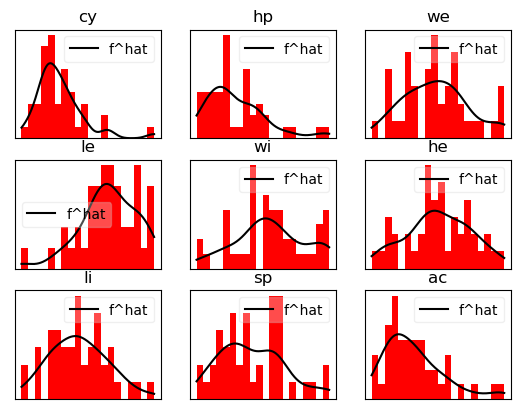

In [19]:
# Get the observed x's for each explanatory variable
t0 = 0
x_cont0 = dat[dat['market'] == t0][nest_contvars].values.reshape((J[t0],len(nest_contvars)))
x_min0 = x_cont0[1:,:].min(axis = 0) # min of x's different from outside option
x_max0 = x_cont0[1:,:].max(axis = 0) # max -=-
n_points = 200
K0 = plot_kernel_estimate(x_cont0, nest_contvars, x_min0, x_max0, n_points, J[t0], outside_option = OO)

x_pairs = iter.product(np.arange(3), np.arange(3))
num_bins = 20

fig, axes = plt.subplots(3, 3)

for p,d in zip(x_pairs, np.arange(len(nest_contvars))):
    axes[p].hist(x_cont0[1:,d], num_bins, color = 'r', alpha = 1, density = True)
    axes[p].plot(np.linspace(x_min0[d], x_max0[d], n_points), K0[d,:], color = 'black', label = 'f^hat')
    axes[p].legend(framealpha = 0.3)
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)
    axes[p].set_title(nest_contvars[d])
    

plt.show()

## The space of characteristics

To get a sense of how we have chosen to model the similarity of products $j$ in the spaces of continuous characteristics $g$, we construct a scatterplot with the vectors $\psi^g_{(j)}$ against the characteristics $w_{(g)} = X_{t,k(g)}$ of products for market $t = 1$. To reduce overplotting we only plot the rows $\psi^g_{(j)}$ for a median product $j^g = \mathrm{med}(X_{t,k(g)})$ of each nesting structure $g$. Clearly, by construction, the distribution of characteristics in the space of characteristics of any vehicle $j$ will be Gaussian.

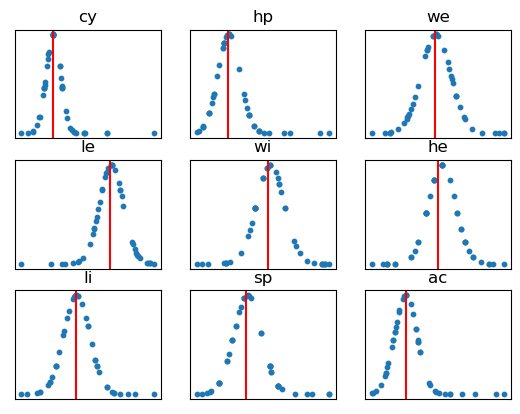

In [20]:
x_medindex0 = np.empty((len(nest_contvars),), dtype = 'int64')

for d in np.arange(len(nest_contvars)):
    x_medindex0[d] = np.int64(np.argwhere(x_cont0[1:,d] == np.percentile(x_cont0[1:,d], 50, interpolation = 'higher'))[0])

x_pairs = iter.product(np.arange(3), np.arange(3))
num_bins = 20

fig, axes = plt.subplots(3, 3)

for p,d in zip(x_pairs, np.arange(len(nest_contvars))):
    if OO:
        axes[p].scatter(x_cont0[1:,d], Psi[0][(np.int64((d+2)*J[0]) + 1):(np.int64((d+3)*J[0])), x_medindex0[d] + 1], s = 10)
    else:
        axes[p].scatter(x_cont0[1:,d], Psi[0][np.int64((d+1)*J[0]):np.int64((d+2)*J[0]), x_medindex0[d]], s = 10)
    axes[p].axvline(np.median(x_cont0[1:,d]), color = 'r', label = 'median')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)
    axes[p].set_title(nest_contvars[d])

plt.show()